In [91]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [92]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from lib.functions import *

In [93]:
###--- Import spatial data ---###

### Read in the data
df = pd.read_csv('data.csv')

### Generate the arrays needed from the dataframe
data = np.array(df["bicycle.theft"])
xi = np.array(df['xi'])
yi = np.array(df['yi'])
print(df)
N = len(data)
coords = [(xi[i],yi[i]) for i in range(N)]

### Subsample the original data set
subsample_factor = 3
idx = subsample(N, subsample_factor, seed=42)
G = get_G(N,idx)
c = G @ data

     bicycle.theft         x         y  xi  yi
0              0.0  0.000000  0.142857   0   3
1              0.0  0.000000  0.190476   0   4
2              2.0  0.058824  0.142857   1   3
3              0.0  0.058824  0.190476   1   4
4              0.0  0.058824  0.238095   1   5
..             ...       ...       ...  ..  ..
202            1.0  0.882353  0.476190  15  10
203            0.0  0.941176  0.190476  16   4
204            0.0  0.941176  0.238095  16   5
205            0.0  0.941176  0.285714  16   6
206            1.0  1.000000  0.190476  18   4

[207 rows x 5 columns]


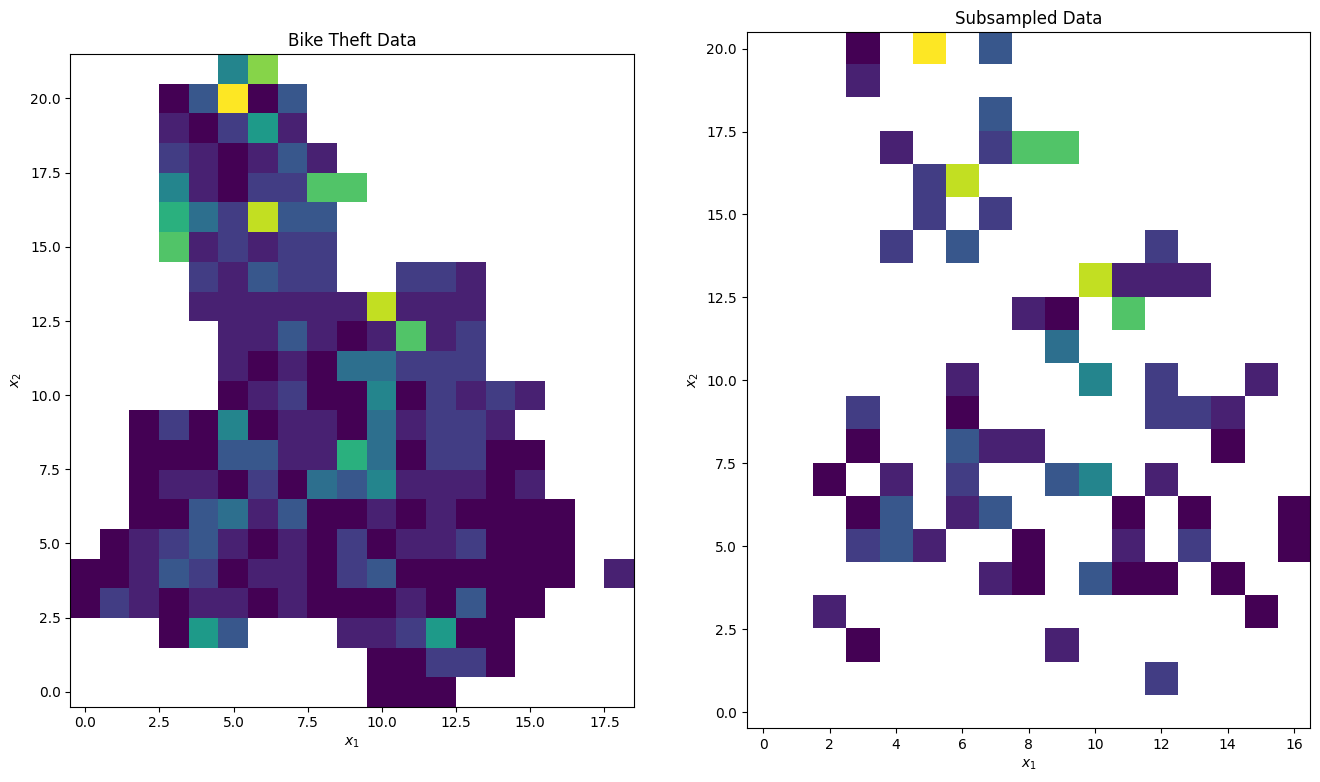

In [94]:
fig, ax = plt.subplots(1, 2, figsize=(16, 12))

plot_2D(data, xi, yi, fig, ax[0], title='Bike Theft Data')                   # Plot bike theft count data
plot_2D(c, xi[idx], yi[idx], fig, ax[1], title='Subsampled Data')      # Plot subsampled data

plt.show()

In [95]:
###--- MCMC ---####

### Set MCMC parameters
n = 10000
beta = 0.2

### Set the likelihood and target, for sampling p(u|c)
log_target = log_poisson_target
log_likelihood = log_poisson_likelihood


# TODO: Complete Spatial Data questions (e), (f).


In [96]:
l = 1.2
K = GaussianKernel(coords, l)
Kc = np.linalg.cholesky(K + 1e-6 * np.eye(N))

In [97]:
X, r = pcn(log_likelihood, Kc @ np.random.randn(N, ), c, K, G, n, beta)
print(r)
m = np.mean(np.exp(X), axis=0)
m = np.clip(m, 0, np.max(m))

0.255


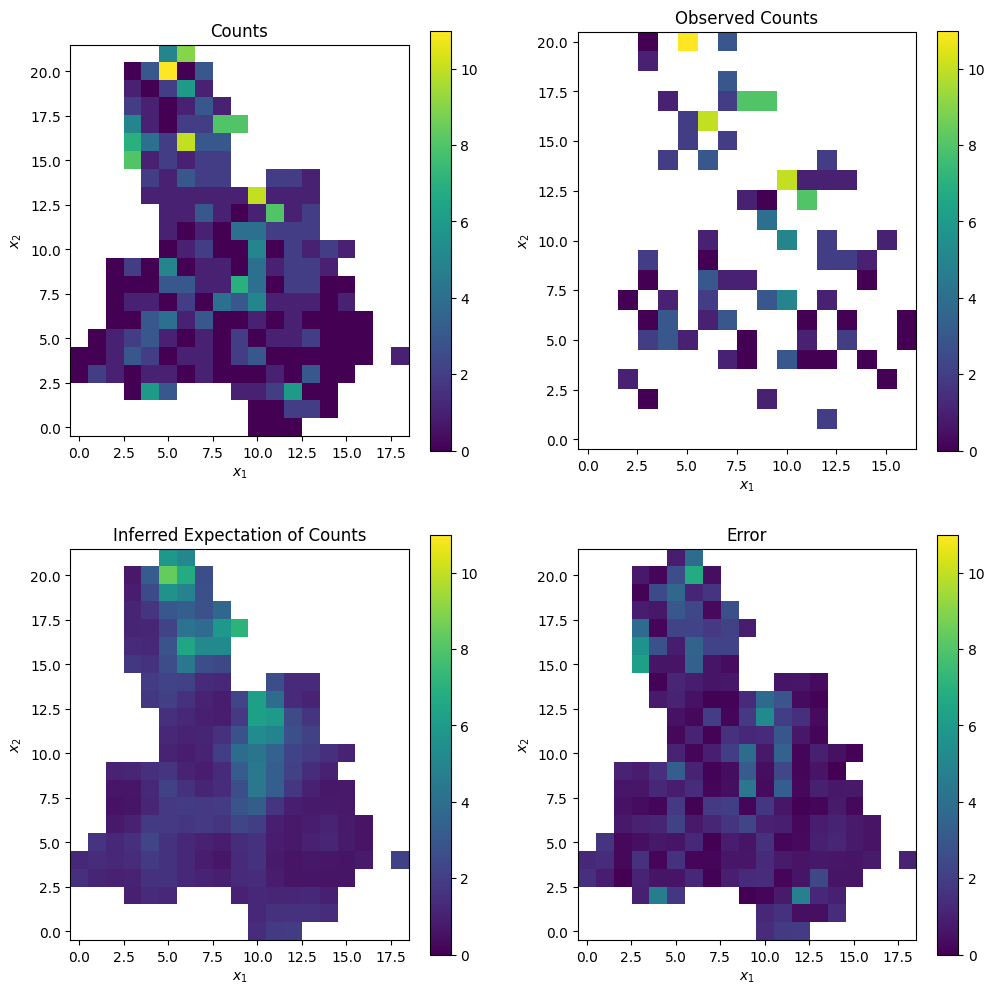

In [98]:
fig, ax = plt.subplots(2, 2, figsize=(12, 12))
plot_2D(data, xi, yi, fig, ax[0, 0], title="Counts", cbar=0, clims=[0, 11])
plot_2D(c, xi[idx], yi[idx], fig, ax[0, 1], title="Observed Counts", cbar=0, clims=[0, 11])
plot_2D(m, xi, yi, fig, ax[1, 0], title="Inferred Expectation of Counts", cbar=0, clims=[0, 11])
plot_2D(np.abs(m - data), xi, yi, fig, ax[1, 1], title="Error", cbar=0, clims=[0, 11])

fig.savefig("figures/spatial_fit.pdf", dpi=200, bbox_inches='tight')
plt.show() 

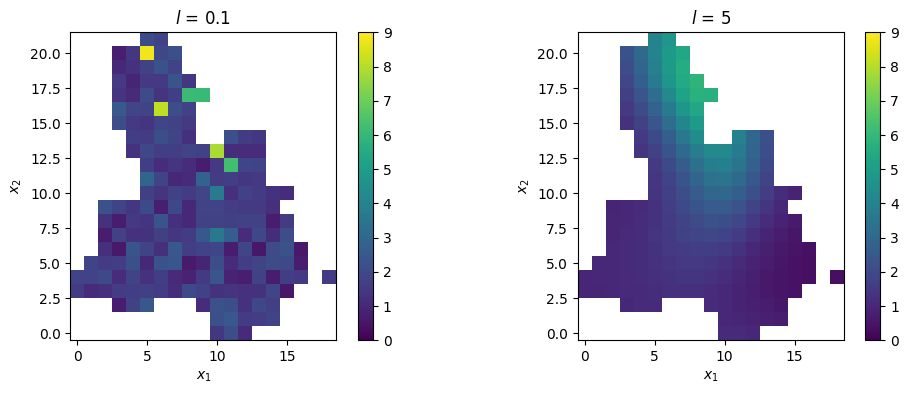

In [90]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
for i, l in enumerate([0.1, 5]):
    K = GaussianKernel(coords, l)
    Kc = np.linalg.cholesky(K + 1e-6 * np.eye(N))
    X, r = pcn(log_likelihood, Kc @ np.random.randn(N, ), c, K, G, n, beta)
    m = np.average(np.exp(X), axis=0)
    m = np.clip(m, 0, np.max(m))
    plot_2D(m, xi, yi, fig, ax[i], title=f"$l$ = {l}", cbar=0, clims=[0, 9])

fig.savefig("figures/vary_l.pdf", dpi=200, bbox_inches='tight')
plt.show() 

$$ p(\mathbf{v}) = \int{p(\mathbf{v}|\mathbf{u})p(\mathbf{u})}d\mathbf{u} = \frac{1}{N}\sum_j^n{p(\mathbf{v}|\tilde{\mathbf{u}})} \quad \quad \quad \tilde{\mathbf{u}} \sim \mathcal{N}(0, C)$$

In [83]:
L = 25
out = np.zeros(L)
x = np.geomspace(0.1, 10, L)
samples = 100000

for i, l in enumerate(x):
    K = GaussianKernel(coords, l)
    Kc = np.linalg.cholesky(K + 1e-6 * np.eye(N))
    o = 0
    for j in range(samples):
        o += log_likelihood(Kc @ np.random.randn(N, ), c, G)
    o /= samples
    out[i] = o    

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


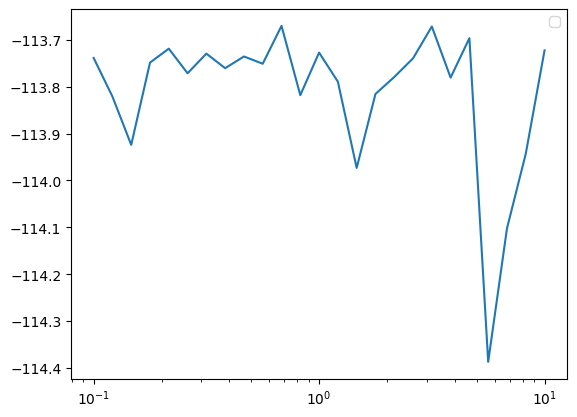

In [84]:
plt.xscale("log")
plt.plot(x, out)
plt.legend()

In [85]:
L = 200
out = np.zeros(L)
x = np.geomspace(0.05, 3, L)

for i, l in enumerate(x):
    K = GaussianKernel(coords, l)
    Kc = np.linalg.cholesky(K + 1e-6 * np.eye(N))
    X, r = pcn(log_likelihood, Kc @ np.random.randn(N, ), c, K, G, n, beta)
    m = np.mean(np.exp(X), axis=0)
    m = np.clip(m, 0, np.max(m))
    out[i] = np.std(m - data)

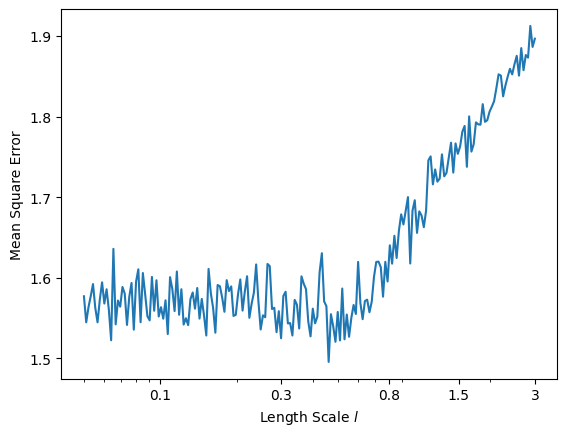

In [86]:
plt.xscale("log")
plt.plot(x, out)
xx = [0.1, 0.3, 0.8 , 1.5, 3]
plt.xticks(ticks=xx, labels=xx)
plt.xlabel("Length Scale $l$")
plt.ylabel("Mean Square Error")
plt.savefig("figures/error_min.pdf", dpi=200, bbox_inches="tight")
plt.show()